# Task 1 - Train XGBoost model

In [1]:
import pandas as pd
import sys

# Support functions
sys.path.insert(0, "./utils/")
import support

import warnings
warnings.simplefilter("ignore")

# Configuration
import yaml

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [2]:
# Read configuration
YAML_PATH = '../conf/'
yaml_file = support.yaml_loader(YAML_PATH + 'yaml_file.yml')

## Load data

In [3]:
pets_df = pd.read_csv('gs://cloud-samples-data/ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv')

## EDA (Exploratory Data Analysis)

* The dataset has 11.5k rows by 14 features (columns)
* The dataset has no missing values
* "Adopted" feature is what we are trying to predict
  * Its value is either "Yes" or "No"
  * Yes represents 73.3% of responses
  * No represents 26.7% of responses

In [4]:
mask_yes = pets_df['Adopted'] == "Yes"
mask_no = pets_df['Adopted'] == "No"
total_rows = pets_df.shape[0]
percent_yes = round(100 * mask_yes.sum() / total_rows, 1)
percent_no = round(100 * mask_no.sum() / total_rows, 1)

print("Data dimensions: {}".format(pets_df.shape))
print("Adopted values   Yes: {}%   No: {}%".format(percent_yes, percent_no))
pets_df.head()

Data dimensions: (11537, 14)
Adopted values   Yes: 73.3%   No: 26.7%


,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,Yes
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,Yes
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,Yes
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,Yes


## Feature columns

* Dataset has 14 features
  * 3 numerical ('Age', 'Fee', 'PhotoAmt')
  * 11 categorical ('Adopted', 'Breed1', 'Color1', 'Color2', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Sterilized', 'Type', 'Vaccinated')
  
| Feature  | Type  | Comments  |
|---|---|---|
| Age  | Numerical  | Range is from 0 to 255 and most likely age in days (255 days is equivalent to 8 months)|
| Fee  | Numerical  | Range is 0 to 2000  |
| PhotoAmt  | Numerical  | Range is 0 to 30  |
| Adopted  | Categorical  | Cardinality is 2 (Yes or No). This is our target feature i.e. what we are trying to predict  |
| Breed1  | Categorical  | Cardinality of 166  |
| Color1  | Categorical  | Cardinality of 7  |
| Color2  | Categorical  | Cardinality of 7  |
| Furlength  | Categorical  | Cardinality of 3  |
| Gender  | Categorical  | Cardinality of 2  |
| Health  | Categorical  | Cardinality of 3  |
| MaturitySize  | Categorical  | Cardinality of 3  |
| Sterilized  | Categorical  | Cardinality of 3  |
| Type  | Categorical  | Cardinality of 2  |
| Vaccinated  | Categorical  | Cardinality of 3  |

In [5]:
all_features = pets_df.columns.tolist()
numerical_features = ['Age', 'Fee', 'PhotoAmt']
categorical_features = sorted(support.list_diff(all_features, numerical_features))

In [6]:
print("Numerical features: {}".format(numerical_features))
print("Categorical features: {}".format(categorical_features))

Numerical features: ['Age', 'Fee', 'PhotoAmt']
Categorical features: ['Adopted', 'Breed1', 'Color1', 'Color2', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Sterilized', 'Type', 'Vaccinated']


In [7]:
# Summary statistics for the 3 numerical features
pets_df.describe()

,Age,Fee,PhotoAmt
count,11537.000000,11537.000000,11537.000000
mean,11.743434,23.957268,3.610211
std,19.324221,80.024226,3.145872
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000
50%,4.000000,0.000000,3.000000
75%,12.000000,0.000000,5.000000
max,255.000000,2000.000000,30.000000


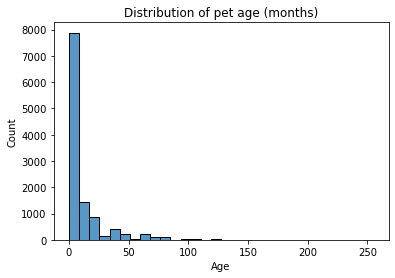

In [8]:
# Distribution of Age numerical feature
sns.histplot(data=pets_df, x='Age', bins=30).set(title='Distribution of pet age (months)')
plt.show()

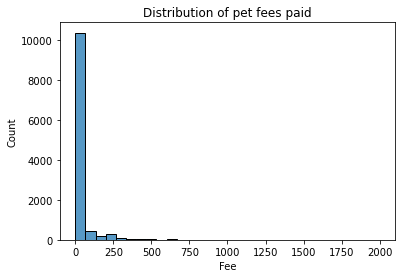

In [9]:
# Distribution of Fee numerical feature
sns.histplot(data=pets_df, x='Fee', bins=30).set(title='Distribution of pet fees paid')
plt.show()

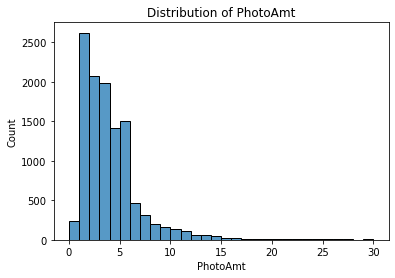

In [10]:
# Distribution of PhotoAmt numerical feature
sns.histplot(data=pets_df, x='PhotoAmt', bins=30).set(title='Distribution of PhotoAmt')
plt.show()

In [11]:
# Cardinality and missing values summary
pets_checked = support.data_check(pets_df)
pets_checked

,Column Name,Unique entries,Unique entries percent,Missing values,Missing values percent
0,Type,2,0.0,0,0.0
1,Age,105,0.9,0,0.0
2,Breed1,166,1.4,0,0.0
3,Gender,2,0.0,0,0.0
4,Color1,7,0.1,0,0.0
5,Color2,7,0.1,0,0.0
6,MaturitySize,3,0.0,0,0.0
7,FurLength,3,0.0,0,0.0
8,Vaccinated,3,0.0,0,0.0
9,Sterilized,3,0.0,0,0.0


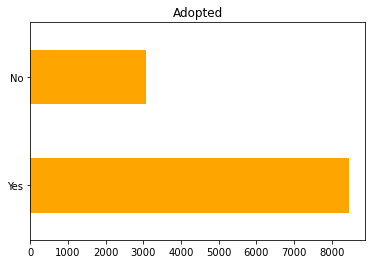

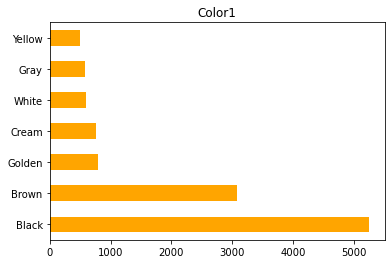

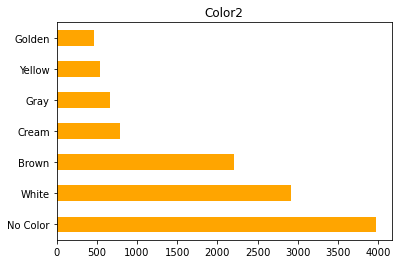

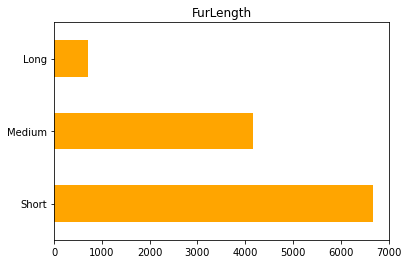

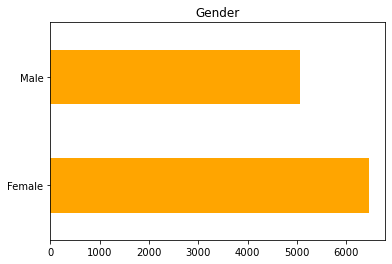

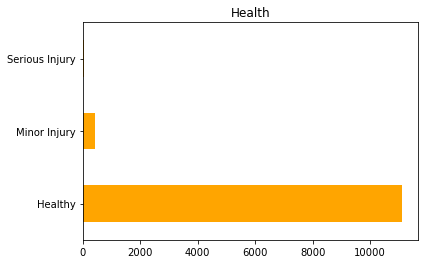

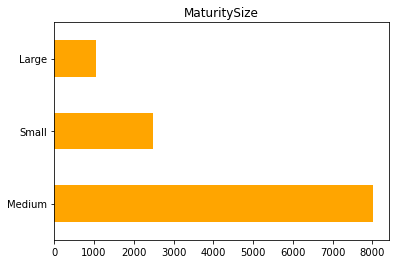

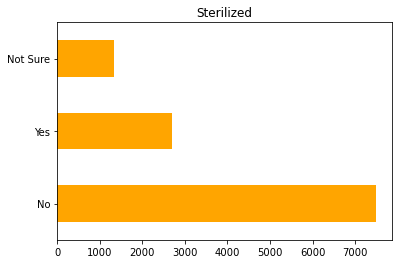

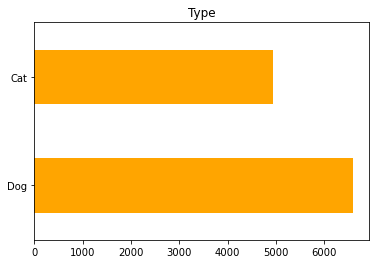

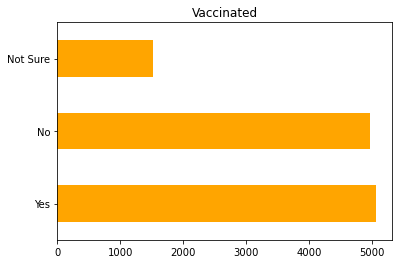

In [12]:
# Check on categorical features with reasonable cardinality
# "Breed1" has cardinality 166 and is not represented here
categorical_list = ['Adopted', 'Color1', 'Color2', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Sterilized', 'Type', 'Vaccinated']
for feature in categorical_list:
    ax = pets_df[feature].value_counts().plot(title=feature, kind='barh', color='orange')
    plt.show()

In [13]:
unique_categories = support.reduce_cardinality(pets_df, column='Breed1', threshold=0.8)
unique_categories

['Mixed Breed',
 'Domestic Short Hair',
 'Domestic Medium Hair',
 'Tabby',
 'Domestic Long Hair',
 'Siamese',
 'Shih Tzu',
 'Persian']

In [14]:
# Filter all pets that match the unique categories
mask = pets_df['Breed1'].isin(unique_categories)

# The complement ~ are pets that are NOT in the list of unique categories. We group them together into a single group called "Other"
pets_df.loc[~mask, 'Breed1'] = 'Other'
pets_df['Breed1'].value_counts()

Mixed Breed             4629
Domestic Short Hair     2605
Other                   2416
Domestic Medium Hair     865
Tabby                    242
Domestic Long Hair       223
Siamese                  202
Shih Tzu                 178
Persian                  177
Name: Breed1, dtype: int64

### Encode "Adopted" feature

* Set Yes = 1
* Set No = 0

In [15]:
pets_df['Adopted'].unique()

array(['Yes', 'No'], dtype=object)

In [16]:
mask_yes = pets_df['Adopted'] == 'Yes'
mask_no = pets_df['Adopted'] == 'No'

# Change value of Yes to 1
pets_df.loc[mask_yes, 'Adopted'] = 1

# Change value of No to 0
pets_df.loc[mask_no, 'Adopted'] = 0

# Convert to integer
pets_df['Adopted'] = pets_df['Adopted'].astype(int)

### One-hot encode categorical features

* XGBoost v1.6+ supports categorical data but comes with a warning that the feature is highly experimental (https://xgboost.readthedocs.io/en/latest/tutorials/categorical.html)
* For now, shall use one-hot encoding using Pandas get_dummies (https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)
* One-hot encoding leads to sparse data and most importantly adds high dimensionality so care has to be taken
* As follow-up work, I shall explore Weight of Evidence and Information Value to group together similar features (https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html) as an alternative to one-hot encoding

In [17]:
print("Dimensions before one-hot encoding: {}".format(pets_df.shape))

categorical_list = ['Breed1', 'Color1', 'Color2', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Sterilized', 'Type', 'Vaccinated']
pets_df = support.create_one_hot_dataframe(pets_df, categorical_list)

print("Dimensions after one-hot encoding: {}".format(pets_df.shape))

Dimensions before one-hot encoding: (11537, 14)
Dimensions after one-hot encoding: (11537, 46)


In [18]:
pets_df.head()

,Age,Fee,PhotoAmt,Adopted,Breed1_Domestic Long Hair,Breed1_Domestic Medium Hair,Breed1_Domestic Short Hair,Breed1_Mixed Breed,Breed1_Other,Breed1_Persian,...,MaturitySize_Medium,MaturitySize_Small,Sterilized_No,Sterilized_Not Sure,Sterilized_Yes,Type_Cat,Type_Dog,Vaccinated_No,Vaccinated_Not Sure,Vaccinated_Yes
0,3,100,1,1,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
1,1,0,2,1,0,1,0,0,0,0,...,1,0,0,1,0,1,0,0,1,0
2,1,0,7,1,0,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,1
3,4,150,8,1,0,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,1
4,1,0,3,1,0,0,0,1,0,0,...,1,0,1,0,0,0,1,1,0,0


In [19]:
pets_df['PhotoAmt'].unique()

array([ 1,  2,  7,  8,  3,  6,  0, 19, 11,  5,  4, 13, 18, 12, 10,  9, 24,
       14, 15, 23, 28, 20, 27, 26, 16, 30, 29, 22, 25, 21, 17],
      dtype=int64)

## Set feature vector and target variable

In [20]:
X = pets_df.drop('Adopted', axis=1)
y = pets_df['Adopted'].values

In [21]:
X.head()

,Age,Fee,PhotoAmt,Breed1_Domestic Long Hair,Breed1_Domestic Medium Hair,Breed1_Domestic Short Hair,Breed1_Mixed Breed,Breed1_Other,Breed1_Persian,Breed1_Shih Tzu,...,MaturitySize_Medium,MaturitySize_Small,Sterilized_No,Sterilized_Not Sure,Sterilized_Yes,Type_Cat,Type_Dog,Vaccinated_No,Vaccinated_Not Sure,Vaccinated_Yes
0,3,100,1,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
1,1,0,2,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,1,0
2,1,0,7,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,1
3,4,150,8,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,1
4,1,0,3,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,1,0,0


## Split data into train, validation and test

* Total rows = 11537
* Train. 60% or 11537 * 0.6 = 6922.2 but we round down to 6921 to accomodate equal validation and test sizes
* Validation. 20% or 11537 * 0.2 = 2307.4 but we round up to 2308 so that the sum of train, validation and test are 11537
* Test. 20% as above i.e. = 2308

In [22]:
# Split into (train and validation), test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2308, random_state=0)

# Then split train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2308, random_state=0)

In [23]:
print("Train: X{}  y{}".format(X_train.shape, y_train.shape))
print("Validation: X{}  y{}".format(X_val.shape, y_val.shape))
print("Test: X{}  y{}".format(X_test.shape, y_test.shape))
print("Entire dataset: {}".format(pets_df.shape))

Train: X(6921, 45)  y(6921,)
Validation: X(2308, 45)  y(2308,)
Test: X(2308, 45)  y(2308,)
Entire dataset: (11537, 46)


## Baseline model

We use sklearn's DummyClassifier to set a baseline model prediction. The strategy is to opt for the most frequent value.

In [24]:
dummy = DummyClassifier(strategy='most_frequent', random_state=0)
dummy.fit(X_train, y_train)

# Make predictions on the test set (model has not seen this before)
y_pred = dummy.predict(X_test)

print("Dummy model scores")
print("F1: {0:0.4f}".format(f1_score(y_test, y_pred)))
print("Accuracy: {0:0.4f}".format(accuracy_score(y_test, y_pred)))
print("Recall: {0:0.4f}".format(recall_score(y_test, y_pred)))

Dummy model scores
F1: 0.8384
Accuracy: 0.7218
Recall: 1.0000


## XGBoost algorithm

### Train model (no early stopping, default parameters)

In [25]:
xgb_clf = XGBClassifier()

# Fit the classifier to the training data
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_clf.fit(X_train, 
            y_train, 
            eval_set=eval_set,
            eval_metric='logloss',
            verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=24, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
# Make predictions on the test set (model has not seen this before)
y_pred = xgb_clf.predict(X_test)

print("XGBoost model scores")
print("F1: {0:0.4f}".format(f1_score(y_test, y_pred)))
print("Accuracy: {0:0.4f}".format(accuracy_score(y_test, y_pred)))
print("Recall: {0:0.4f}".format(recall_score(y_test, y_pred)))

XGBoost model scores
F1: 0.8262
Accuracy: 0.7318
Recall: 0.8830


### Train model (use early stopping, default parameters)

In [27]:
# Get the optimal number of trees. We use this in the early_stoping_rounds .fit method
results = xgb_clf.evals_result()
optimal_trees = support.optimal_number_of_trees(results, metric='logloss')  # for classification we use logloss

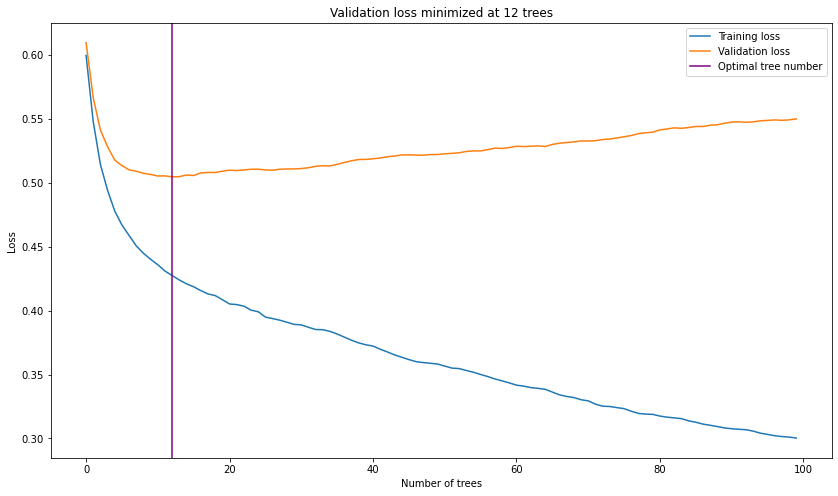

In [28]:
# Plot the training and validation loss. Mark where the validation loss is at a minimum
plt.figure(figsize=(14, 8))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(optimal_trees, color="purple", label="Optimal tree number")
plt.title("Validation loss minimized at {} trees".format(optimal_trees))
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [29]:
# Fit the model again but set early_stopping_rounds
xgb_clf.fit(X_train, 
            y_train,
            early_stopping_rounds=optimal_trees,
            eval_set=eval_set,
            eval_metric='logloss',
            verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=24, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
# Make predictions on the test set (model has not seen this before)
y_pred = xgb_clf.predict(X_test)

print("XGBoost model scores")
print("F1: {0:0.4f}".format(f1_score(y_test, y_pred)))
print("Accuracy: {0:0.4f}".format(accuracy_score(y_test, y_pred)))
print("Recall: {0:0.4f}".format(recall_score(y_test, y_pred)))

XGBoost model scores
F1: 0.8455
Accuracy: 0.7569
Recall: 0.9214


### Train model (use early stopping, scale_pos_weight parameter)

* The dataset has imbalanced classification
* The majority class is "Adopted" and represents 8457/11537 (73.3%)
* The minority class is "Not Adopted" and represents 3080/11537 (26.7%)
* We call the majority class "negative examples" (Adopted)
* We call the minority class "positive examples" (Not Adopted)
* XGBoost offers the scale_pos_weight hyperparameter
  * Scales the gradient for the positive class
  * scale_pos_weight = total_negative_examples / total_positive_examples = 8457 / 3080 = 2.8 
  * scale_pos_weight = 3 (rounded to nearest integer)
  * Reference: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

In [31]:
mask_adopted = pets_df['Adopted'] == 1
mask_notadopted = pets_df['Adopted'] == 0

print("Number of 'adopted' (negative examples): {}".format(mask_adopted.sum()))
print("Number of 'not adopted' (positive examples): {}".format(mask_notadopted.sum()))

Number of 'adopted' (negative examples): 8457
Number of 'not adopted' (positive examples): 3080


In [32]:
xgb_clf = XGBClassifier(scale_pos_weight=3)

# Fit the model again but set early_stopping_rounds
xgb_clf.fit(X_train, 
            y_train,
            early_stopping_rounds=optimal_trees,
            eval_set=eval_set,
            eval_metric='logloss',
            verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=24, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
# Make predictions on the test set (model has not seen this before)
y_pred = xgb_clf.predict(X_test)

print("XGBoost model scores")
print("F1: {0:0.4f}".format(f1_score(y_test, y_pred)))
print("Accuracy: {0:0.4f}".format(accuracy_score(y_test, y_pred)))
print("Recall: {0:0.4f}".format(recall_score(y_test, y_pred)))

XGBoost model scores
F1: 0.8395
Accuracy: 0.7266
Recall: 0.9904


## Model evaluation metrics

### Accuracy
* Accuracy = Number of correct predictions / Total number of predictions = (TP + TN) / (TP + TN + FP + FN)

### Precision
* Precision = TP / (TP + FP)
* What proportion of positive identifications were actually correct?


### Recall
* Recall = TP / (TP + FN)
* What proportion of actual positives were identified correctly?

### F1 score
* F1 score = (2 x Precision x Recall) / (Precision + Recall)
* Weighted average of precision and recall

## Results

|   | Dummy  | XGB  | XGB (early stop)  | XGB (scale_pos_weight)  |
|---|---|---|---|---|
| F1 Score  | 0.8384  | 0.8262  | 0.8455  | 0.8395  |
| Accuracy  | 0.7218  | 0.7318  | 0.7569  | 0.7266  |
| Recall  | 1.0000  | 0.8830  | 0.9214  | 0.9904  |

Best result:
* XGBoost using early stop of 12 trees (with all other hyperparameters set as default)
* Highest F1 score and accuracy

## Confusion matrix

In [34]:
# Reset model to default (no scale_pos_weight)
xgb_clf = XGBClassifier()

# Fit the model again but set early_stopping_rounds
xgb_clf.fit(X_train, 
            y_train,
            early_stopping_rounds=optimal_trees,
            eval_set=eval_set,
            eval_metric='logloss',
            verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=24, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
# Make predictions on the test set (model has not seen this before)
y_pred = xgb_clf.predict(X_test)

print("XGBoost model scores")
print("F1: {0:0.4f}".format(f1_score(y_test, y_pred)))
print("Accuracy: {0:0.4f}".format(accuracy_score(y_test, y_pred)))
print("Recall: {0:0.4f}".format(recall_score(y_test, y_pred)))

XGBoost model scores
F1: 0.8455
Accuracy: 0.7569
Recall: 0.9214


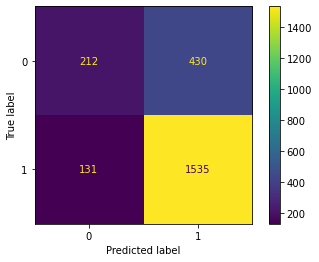

In [36]:
cm = confusion_matrix(y_test, y_pred, labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot()
plt.show()

## Receiver Operating Characteristic (ROC)

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)

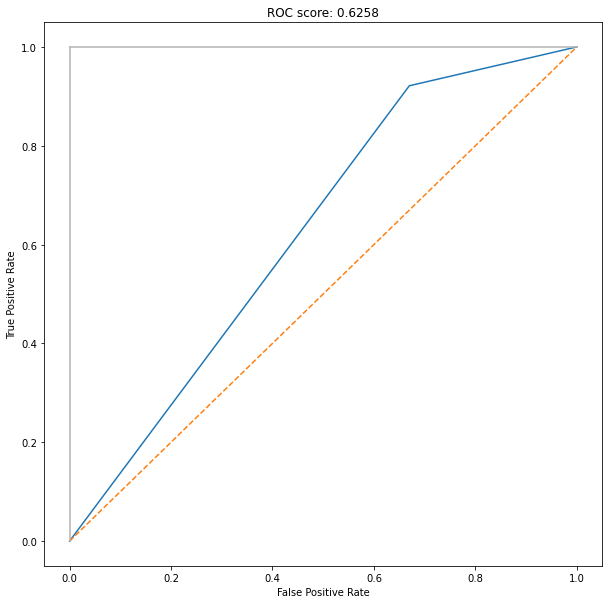

In [38]:
plt.subplots(1, figsize=(10,10))
plt.title("ROC score: {0:0.4f}".format(roc_score))
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Feature importance

* Future investigations could focus on a subset of features, ranked by importance, as input to the training model

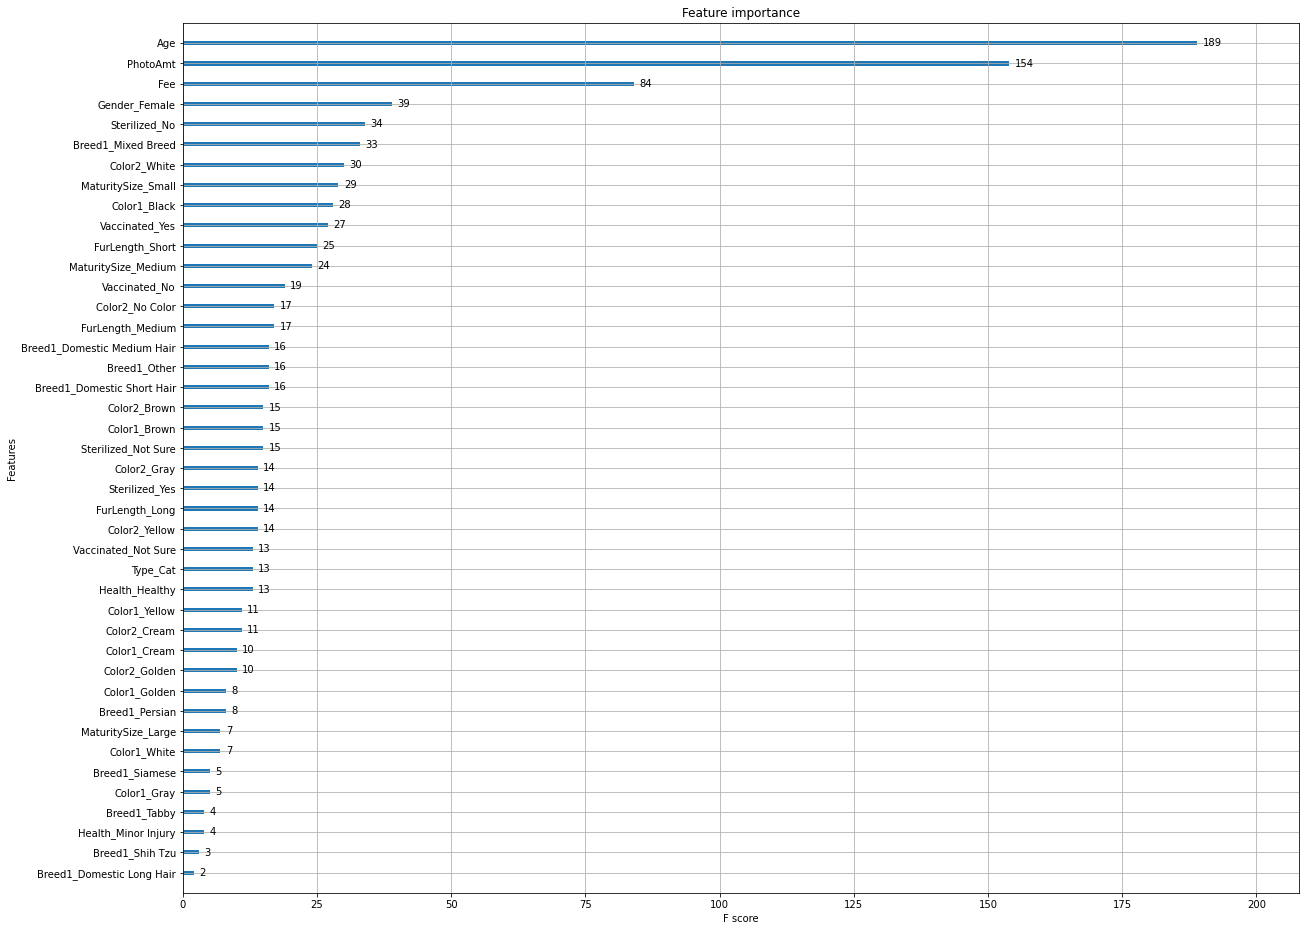

In [39]:
plt.rcParams["figure.figsize"] = (20, 16)

plot_importance(xgb_clf)
plt.show()

## Save model

In [40]:
# save
xgb_clf.save_model(yaml_file['path']['model'] + "task1_xgboost.json")